In [1]:
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

### Here are some functions definations  that we have used for our data analysis task.

In [2]:
def drop_null_columns(df):                 # used to remove columns where 50% or more data is null
    cut_off = int(0.50*len(df))
    null_count = (df[df.columns].isnull()).sum(axis=0)
    drop_columns=null_count[null_count >= cut_off].index.values
    df=df.drop(drop_columns, axis=1)
    return df

def draw_graphs(df1):                         # used to draw graphs of all columns given in passed dataframe
    df1 = df1.loc[df1['LOAN_DEFAULT'] == 1]   # to made comparisioin between fields we have selected examples where loan is defaulted 
    df1=df1.drop('LOAN_DEFAULT', axis=1)
    cols = df1.columns

    for col in cols:
            plot.figure(figsize=(15, 6))
            ax1 = plot.axes()
            ax1 = ax1.set(xlabel=col, ylabel='# of Defaulters')
            freq = list(df1[col])
            freq_set = set(freq)
            plot.hist(freq, bins=len(freq_set))
            plot.show()
            
def cat_encoding(df_to_encode):             # used to encode categorical feilds into numeric values for easy graph ploting and model training
    le = LabelEncoder()
    
    for cols in df_to_encode:
        if df_to_encode[cols].dtype == 'object':
                le.fit(df_to_encode[cols])
                df_to_encode[cols] = le.transform(df_to_encode[cols])
    return df_to_encode
            


### After reading data we have passed the dataframe to remove fields where null values are >50%, however there is no field where null values are > 50%

In [3]:
df=pd.read_csv("data.csv")
print(df.shape)
df=drop_null_columns(df)      
df

(233154, 41)


,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,31-07-1985,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,9/12/1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,1/8/1988,Salaried,...,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0
233150,606141,73651,100600,74.95,34,23775,51,990,5/12/1988,Self employed,...,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0
233151,613658,33484,71212,48.45,77,22186,86,2299,1/6/1976,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,26-03-1994,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


### Below we have converted some variables into their numeric equals so that they can be used in graph analysis 

In [4]:
df['AVERAGE_ACCT_AGE']=(df['AVERAGE_ACCT_AGE'].str.extractall(r'(\d+)')[0]
  .unstack()
  .astype(int)
  .set_axis(['yr', 'mon'], axis=1, inplace=False)
  .eval('yr + mon / 12'))

df['CREDIT_HISTORY_LENGTH']=(df['CREDIT_HISTORY_LENGTH'].str.extractall(r'(\d+)')[0]
  .unstack()
  .astype(int)
  .set_axis(['yr', 'mon'], axis=1, inplace=False)
  .eval('yr + mon / 12'))

now = pd.Timestamp('now')
df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'] , exact=False)
df['DATE_OF_BIRTH'] = df['DATE_OF_BIRTH'].where(df['DATE_OF_BIRTH'] < now, df['DATE_OF_BIRTH'] -  np.timedelta64(100, 'Y'))
df['AGE'] = (now - df['DATE_OF_BIRTH']).astype('<m8[Y]')
df=df.drop('DATE_OF_BIRTH',axis=1)

df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH','AGE' ]]

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,AGE
0,0.000000,0.000000,35.0
1,1.916667,1.916667,35.0
2,0.000000,0.000000,35.0
3,0.666667,1.250000,27.0
4,0.000000,0.000000,43.0
...,...,...,...
233149,1.750000,3.250000,33.0
233150,0.500000,0.500000,32.0
233151,0.000000,0.000000,45.0
233152,0.000000,0.000000,26.0


### Here we have filled the null values in 'EMPLOYMENT_TYPE' field and generate the numeric encodings for remaining categorical fields.

In [5]:
print(df.dtypes.value_counts())
df=df.fillna(value={'EMPLOYMENT_TYPE':'NA'})
df=cat_encoding(df)
df.dtypes.value_counts()

int64      34
float64     4
object      3
dtype: int64


int64      34
float64     4
int32       3
dtype: int64

### Now we have numeric representation of all fields, so we have plotted the graphs of all fields which represents the frequency of defaulters against the values of the field.

### Here we can analyze some graphs (i.e. 'DISBURSED_AMOUNT','PERFORM_CNS_SCORE', 'NO_OF_INQUIRIES') capture more variation thus more representative and some of them are less representative (i.e 'SUPPLIER_ID', 'CURRENT_PINCODE', 'EMPLOYEE_CODE_ID'). So by using these graphs we can identify only important fields.

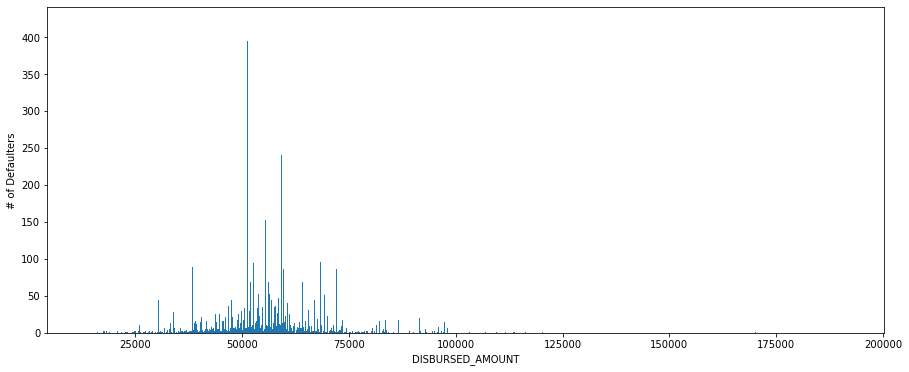

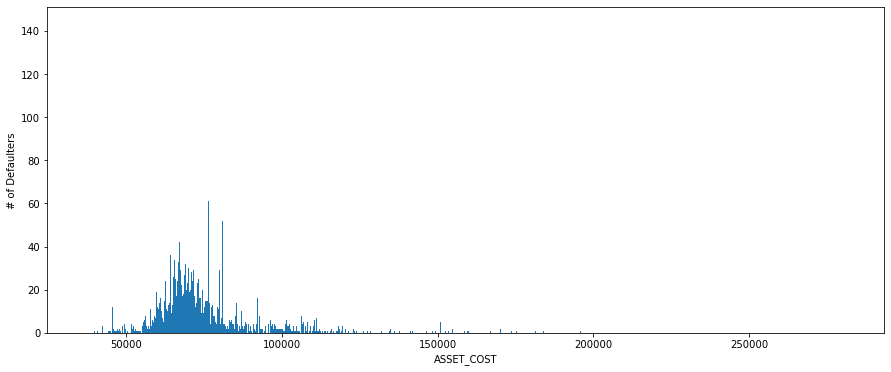

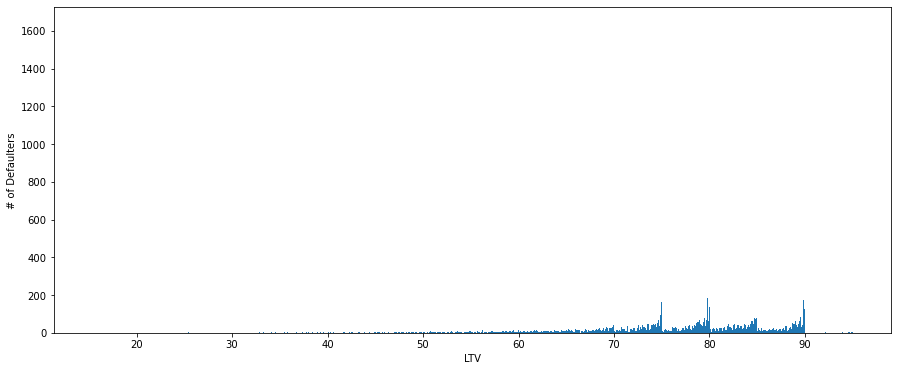

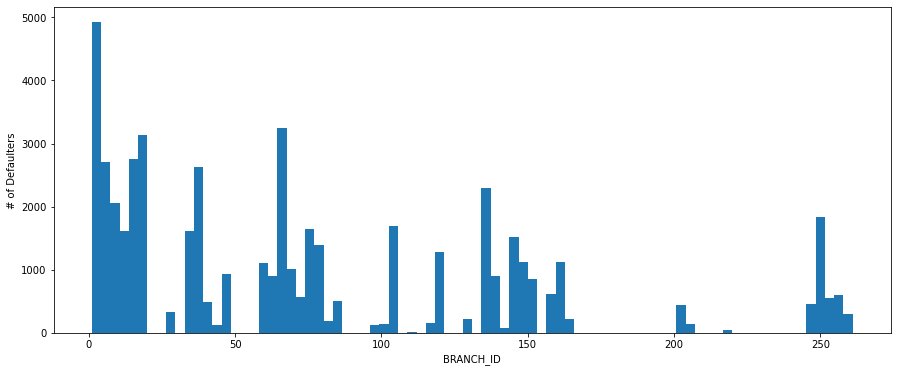

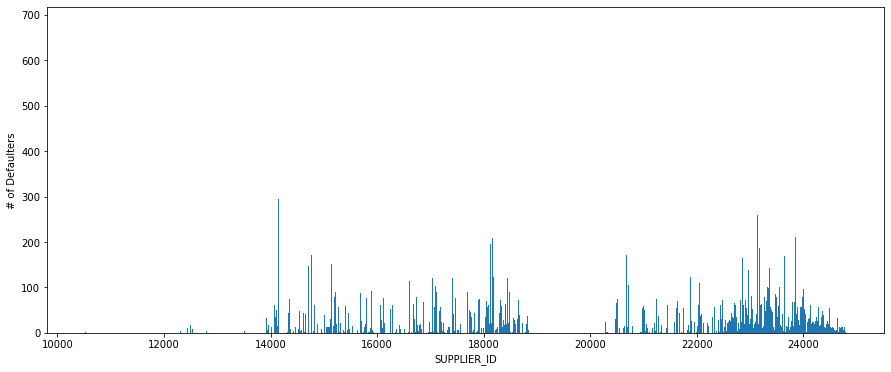

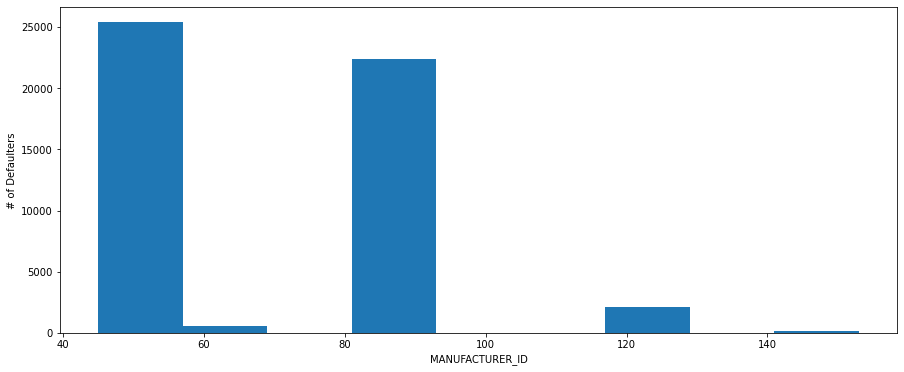

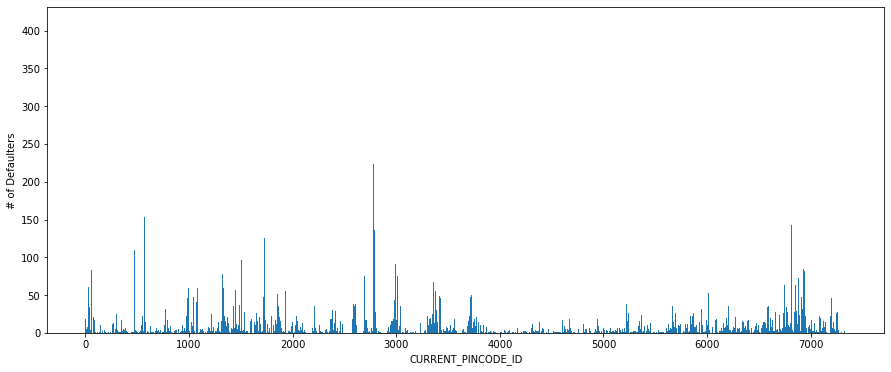

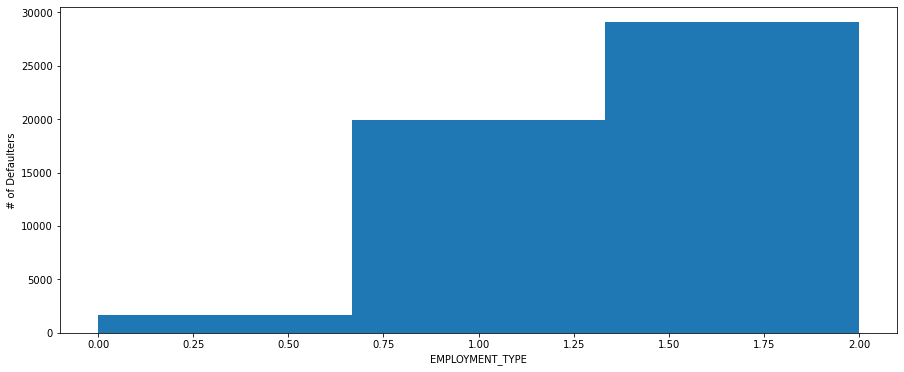

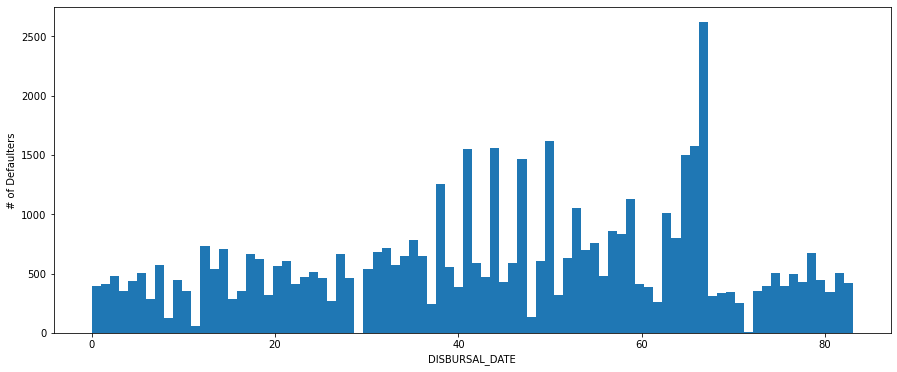

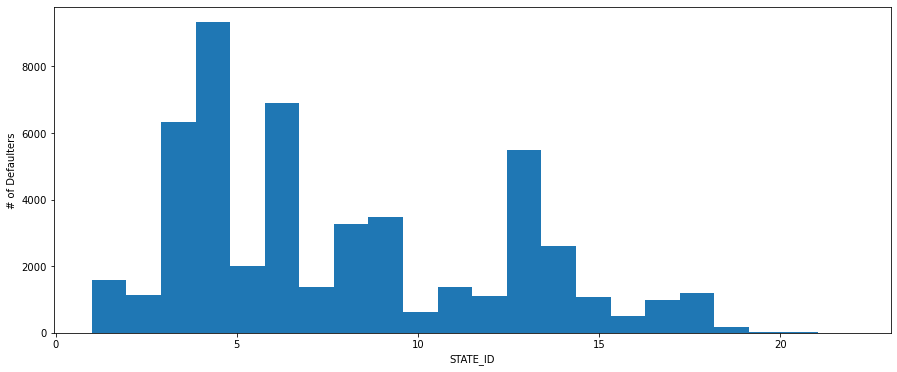

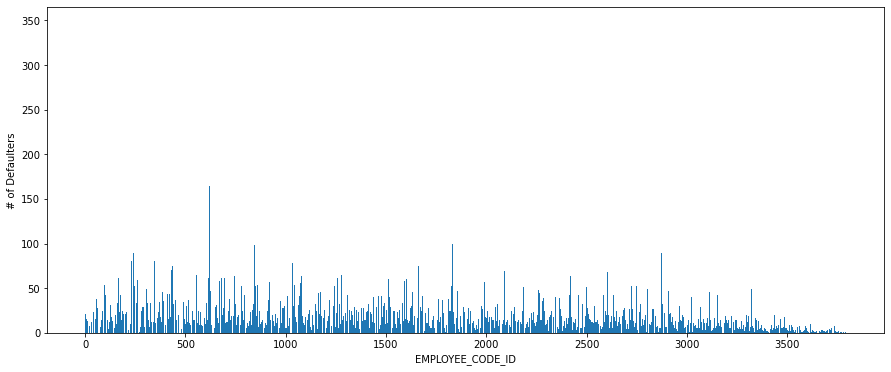

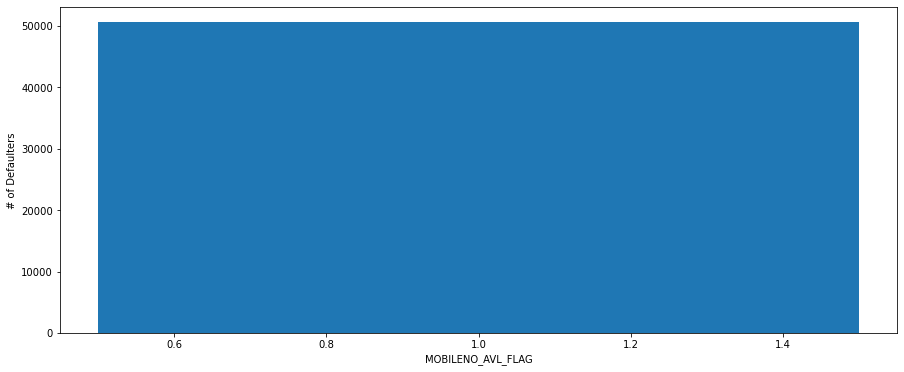

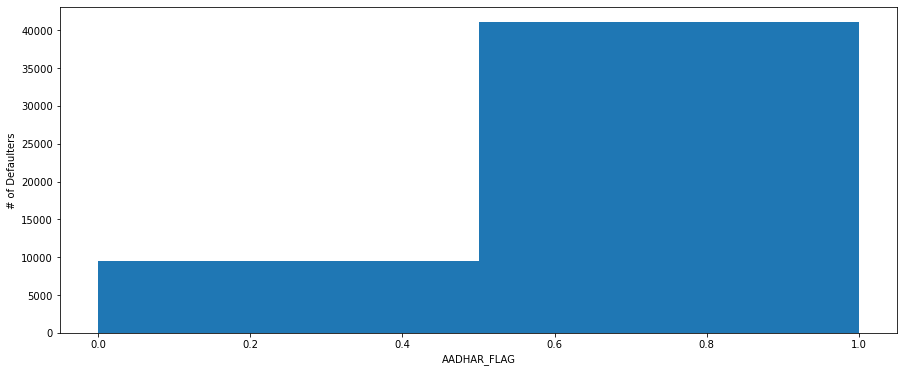

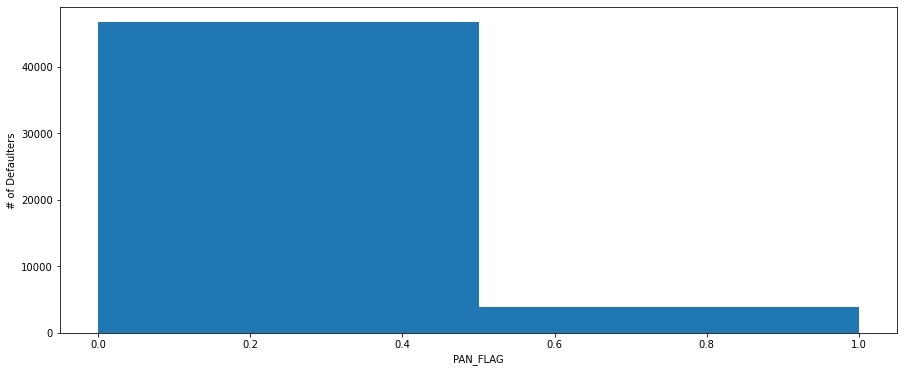

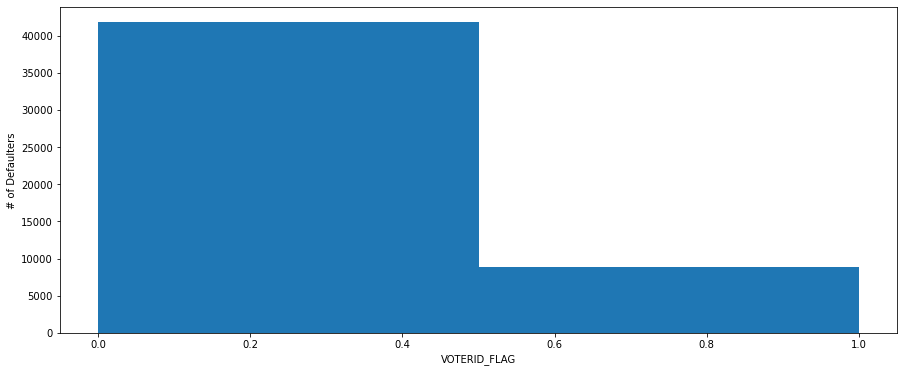

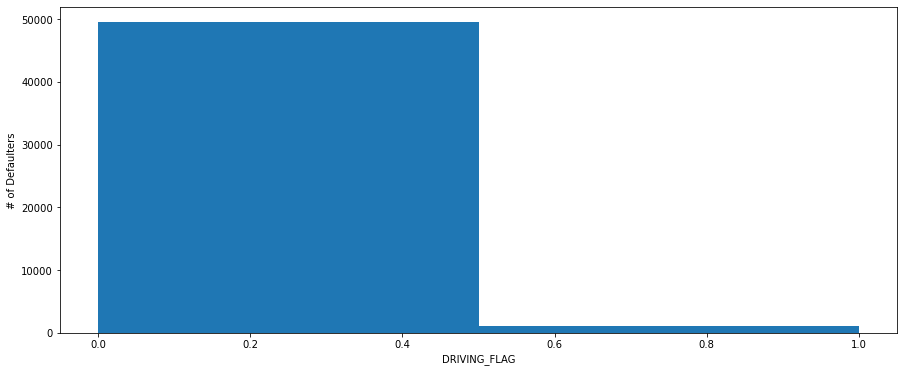

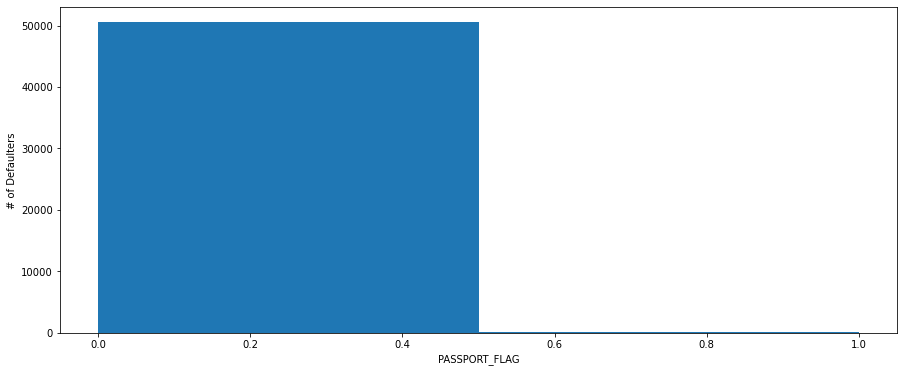

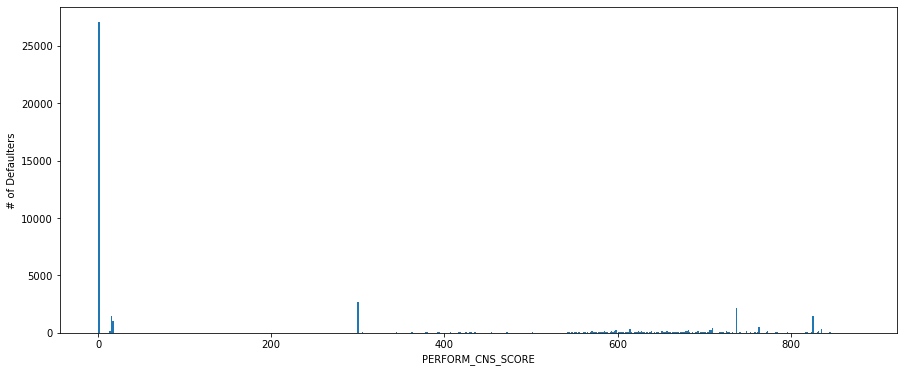

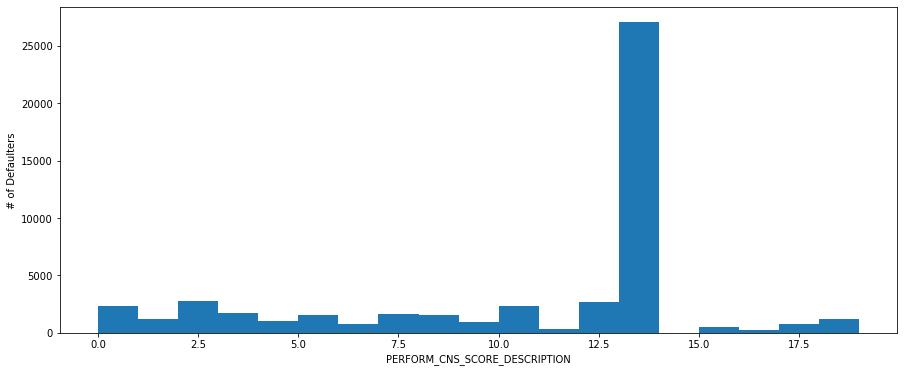

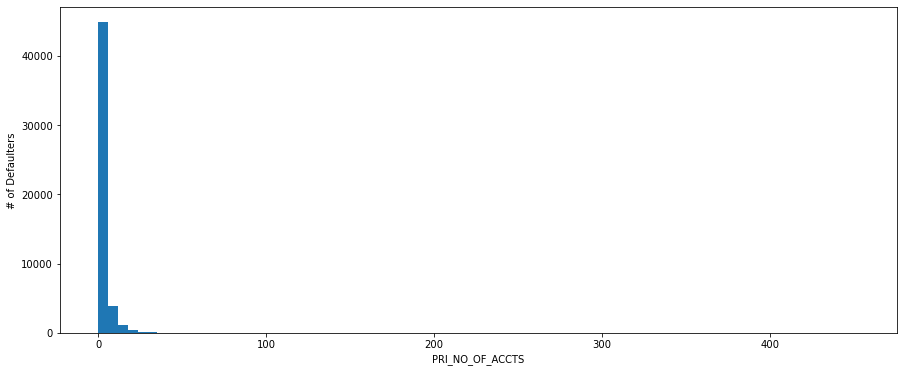

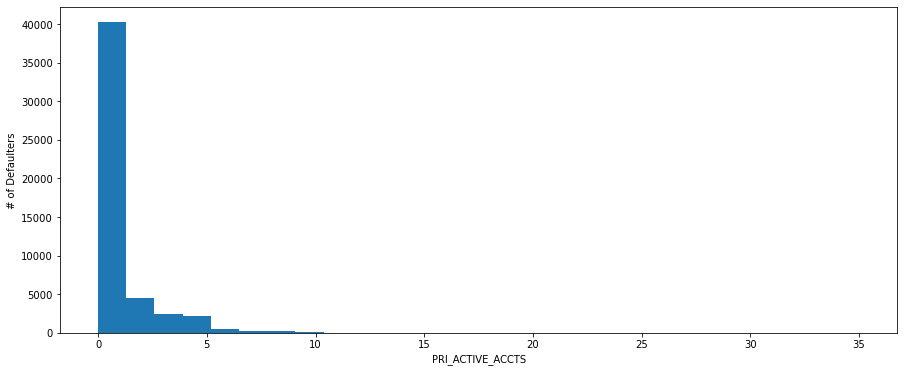

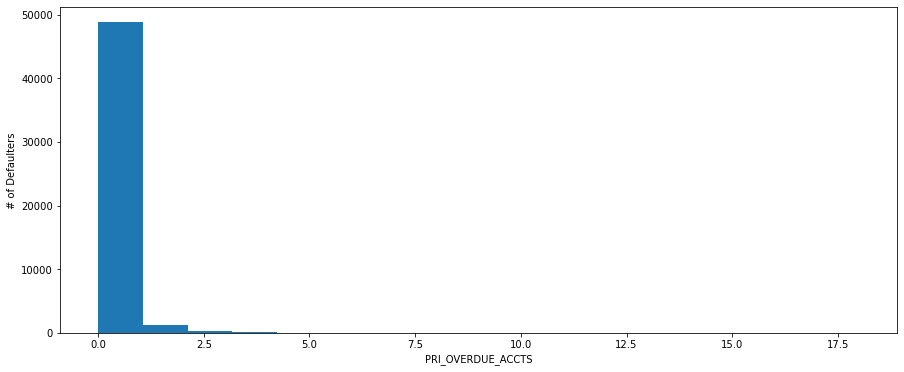

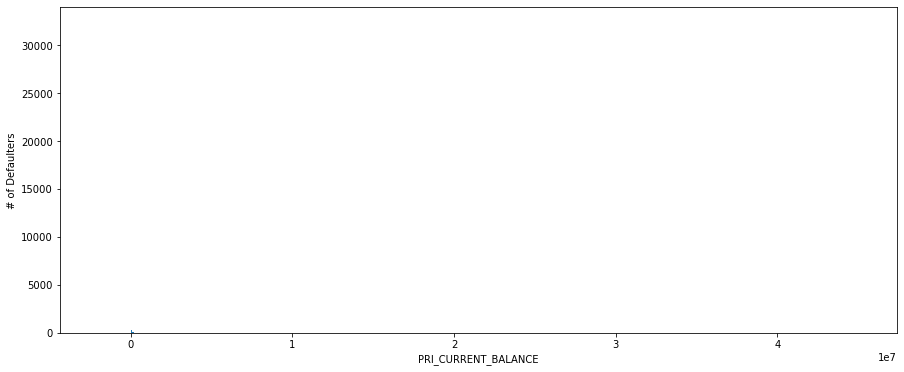

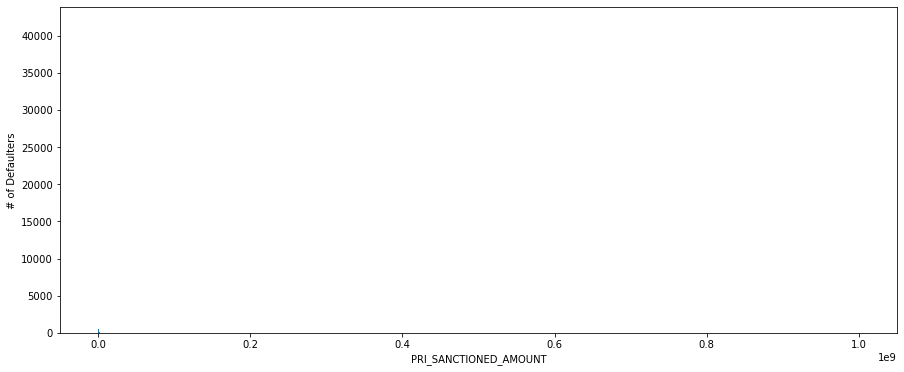

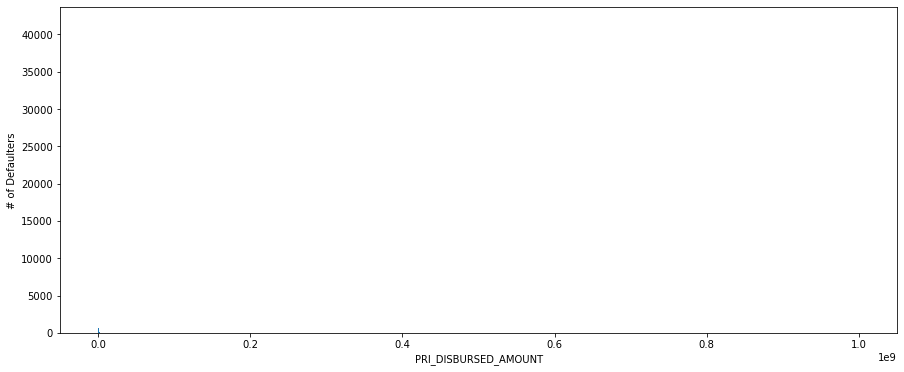

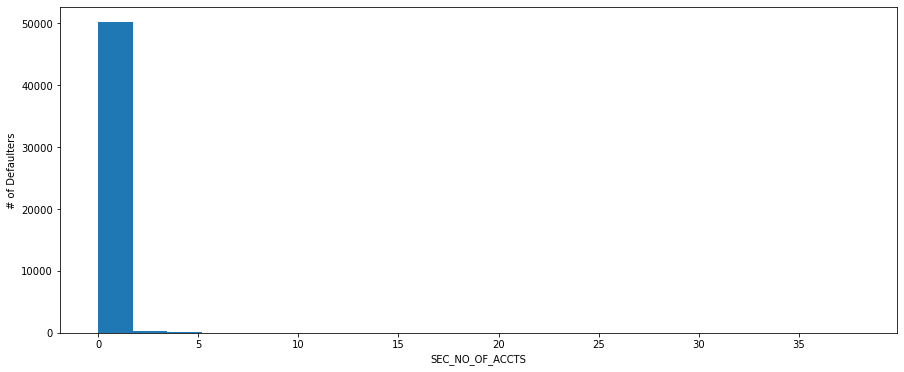

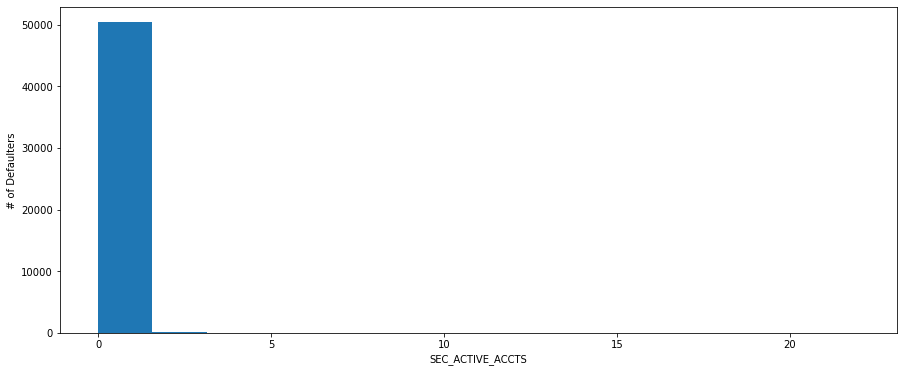

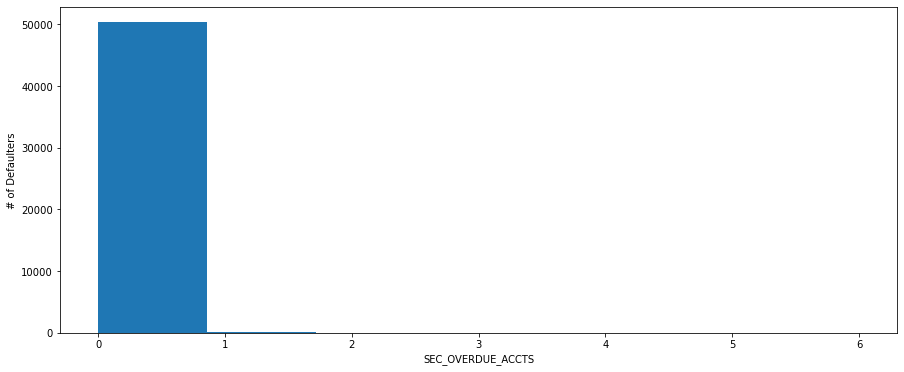

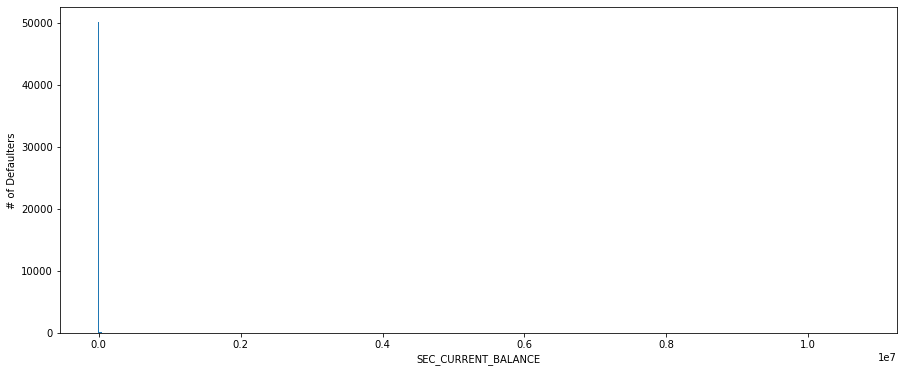

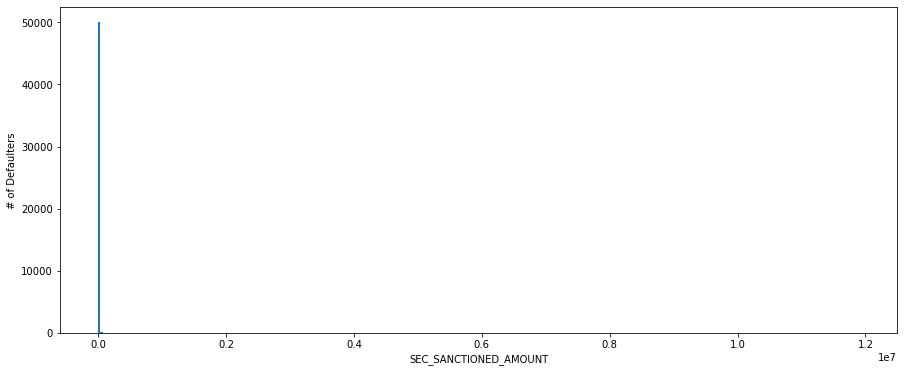

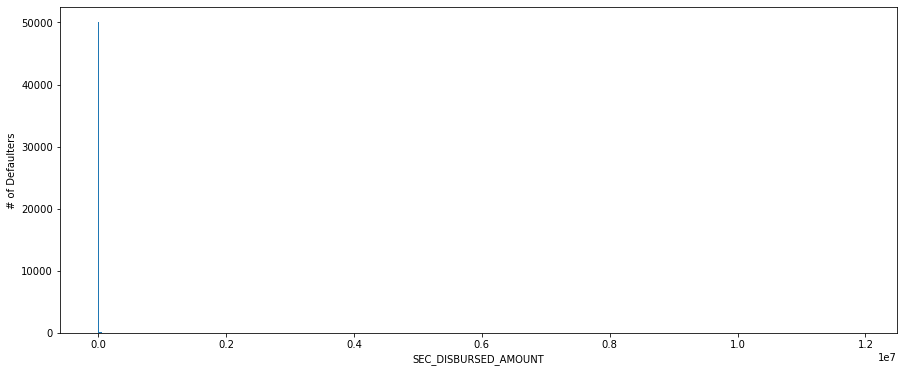

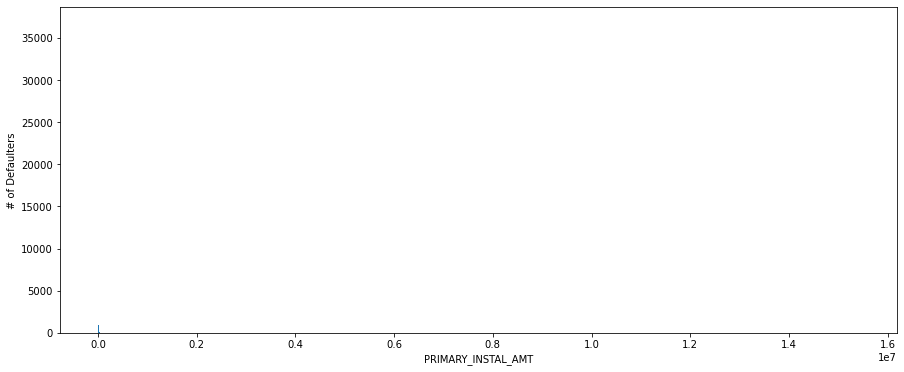

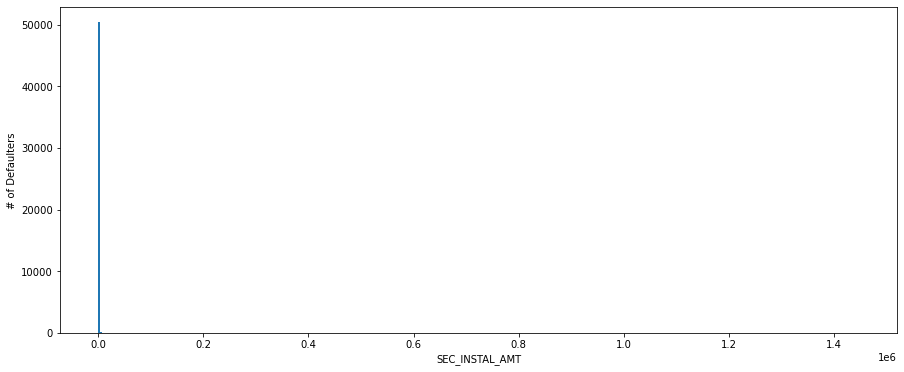

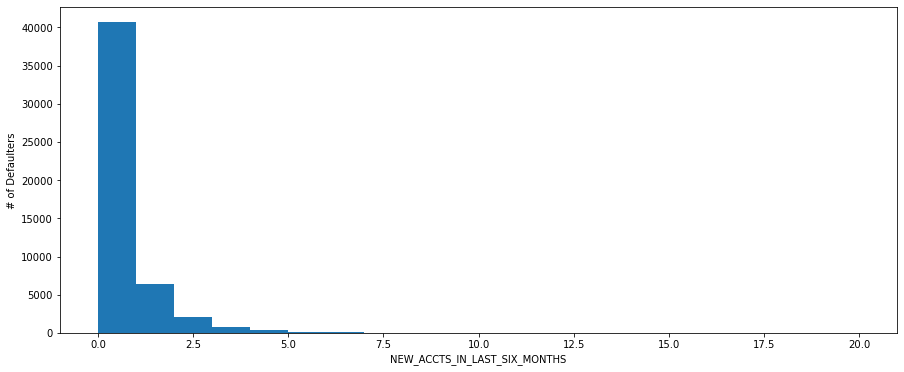

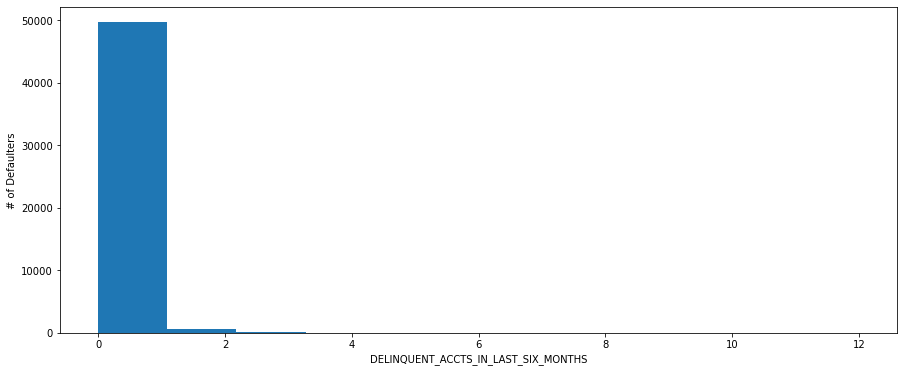

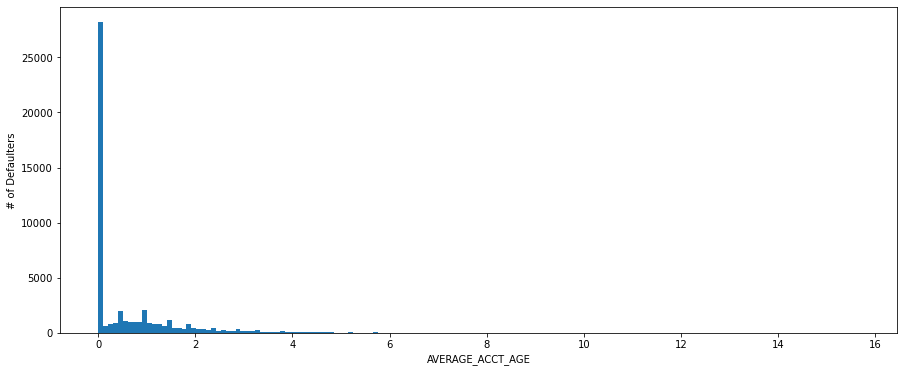

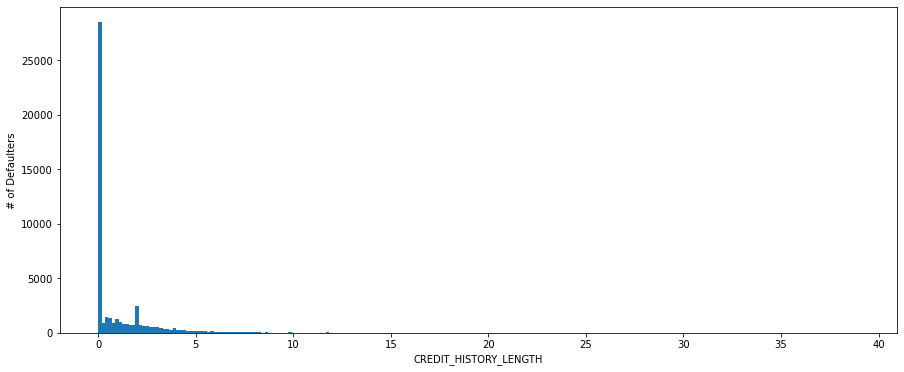

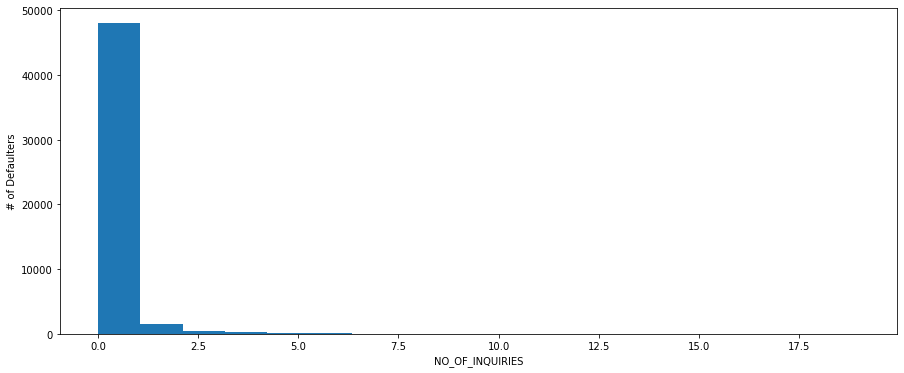

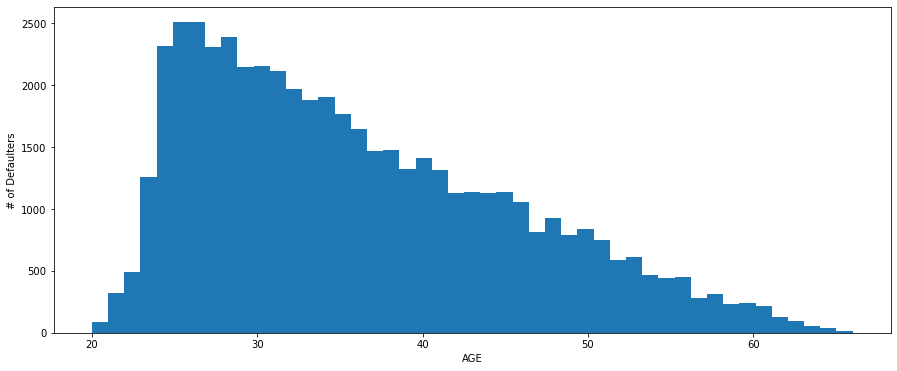

In [6]:
draw_graphs(df.drop(['UNIQUEID'], axis=1))

### To analyze whether demographic data plays a major role in a loanee defaulting his/her loan or the financial data, we  used PCA in which we have generated the priciple components of demographic and financial fields. After generating principle components we have plotted against target varible. By analyzing graphs we can say that demographic data is little more contributing towards target variable. 

Demographic variation captured value: [0.299851]
Financial variation captured value: [0.1981854]


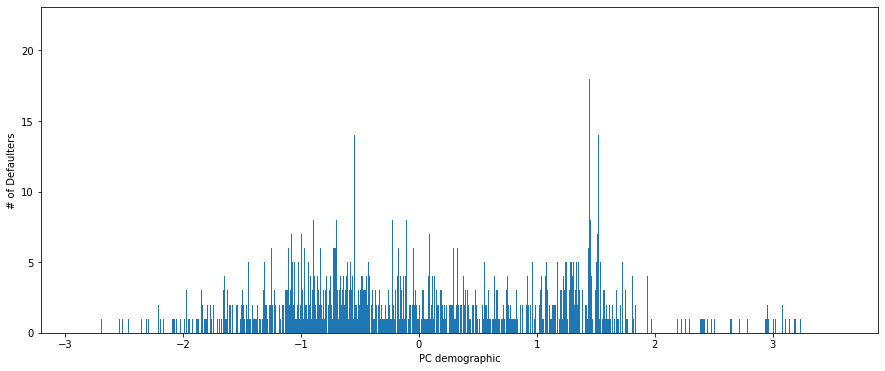

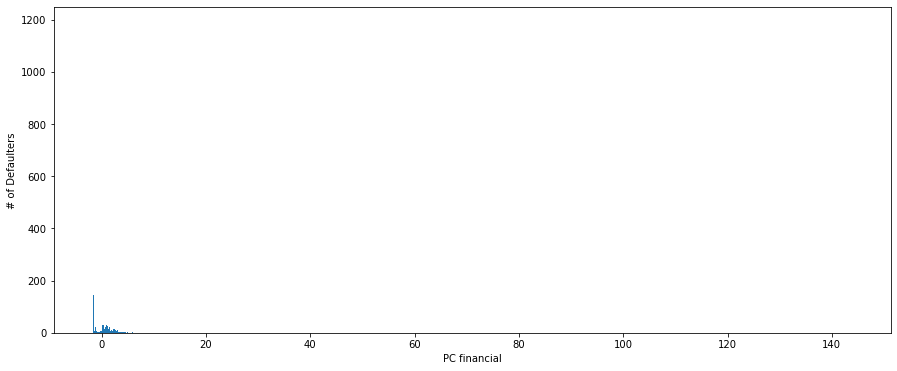

In [9]:
demographic = ['CURRENT_PINCODE_ID','EMPLOYMENT_TYPE', 'AGE', 'STATE_ID']

financial = ['DISBURSED_AMOUNT','ASSET_COST','LTV','PERFORM_CNS_SCORE','PERFORM_CNS_SCORE_DESCRIPTION','PRI_NO_OF_ACCTS'
             ,'PRI_ACTIVE_ACCTS','PRI_OVERDUE_ACCTS','PRI_CURRENT_BALANCE','PRI_SANCTIONED_AMOUNT','PRI_DISBURSED_AMOUNT'
             ,'SEC_NO_OF_ACCTS','SEC_ACTIVE_ACCTS','SEC_OVERDUE_ACCTS','SEC_CURRENT_BALANCE','SEC_SANCTIONED_AMOUNT'
             ,'SEC_DISBURSED_AMOUNT','PRIMARY_INSTAL_AMT','SEC_INSTAL_AMT','NEW_ACCTS_IN_LAST_SIX_MONTHS'
             ,'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS','AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']


x = df.loc[:, demographic].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC demographic'])
print("Demographic variation captured value: " + str(pca.explained_variance_ratio_))

principalDf_d = pd.DataFrame(data = principalComponents
             , columns = ['PC demographic'])

x = df.loc[:, financial].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC financial'])
print("Financial variation captured value: "+ str(pca.explained_variance_ratio_))

principalDf_f = pd.DataFrame(data = principalComponents
             , columns = ['PC financial'])

finalDf_d = pd.concat([principalDf_d, df[['LOAN_DEFAULT']]], axis = 1)
draw_graphs(finalDf_d)

finalDf_f = pd.concat([principalDf, df[['LOAN_DEFAULT']]], axis = 1)
draw_graphs(finalDf_f)

### To verifiy the demographic data contribution towards target variable we have calculated corelation between target variable and other fields. After that we calculated the average coorealtion value between demographic and financial fields which also shows demographic data has little more contribution towards target.

In [10]:
corr_mat = df.corr()
loan_corr=corr_mat['LOAN_DEFAULT'].sort_values(ascending = False)
demograpic_corr=[]
financial_corr=[]

for c in demographic:
    demograpic_corr.append(abs(corr_mat.at['LOAN_DEFAULT',c]))
for c in financial:
    financial_corr.append(abs(corr_mat.at['LOAN_DEFAULT',c]))

print("Demographic corelation value: "+ str(sum(demograpic_corr) / len(demograpic_corr)))
print("Financial corelation value: "+str(sum(financial_corr) / len(financial_corr)))

Demographic corelation value: 0.03422342725469324
Financial corelation value: 0.028814281416540265


### By using corelation values of fields we can find best fields for future analysis.

In [13]:
cor=abs(loan_corr).sort_values(ascending = False)
best_features=list(cor[1:10].keys())
print("Here is list of most representative features: \n"+ str(best_features))

Here is list of most representative features: 
['LTV', 'DISBURSED_AMOUNT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'PERFORM_CNS_SCORE', 'STATE_ID', 'VOTERID_FLAG', 'NO_OF_INQUIRIES', 'CREDIT_HISTORY_LENGTH', 'AADHAR_FLAG']


### Creating training(80%) and test set(20%) for model training

In [14]:
X =df.drop('LOAN_DEFAULT', axis=1)   
y = df['LOAN_DEFAULT']  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
print(X_train.shape)

(186523, 40)


### Below we have trained and evaluated diffrent ML models for this dataset. Since we do not have equal no. of examples of each class in dataset so F1-score is the most suitable performance measure. In our experimentation decision tree perform better than other classifiers with F1-score= 0.53 so it can be used as predictor.

In [15]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter=400)
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

C:\Users\Yasir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.79      1.00      0.88     36614
           1       0.00      0.00      0.00     10017

    accuracy                           0.79     46631
   macro avg       0.39      0.50      0.44     46631
weighted avg       0.62      0.79      0.69     46631



[[36611     3]
 [10017     0]]


In [18]:
from sklearn.ensemble  import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
print(classification_report(y_test,y_predict))
print('\n')
print(confusion_matrix(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     36614
           1       0.47      0.03      0.06     10017

    accuracy                           0.78     46631
   macro avg       0.63      0.51      0.47     46631
weighted avg       0.72      0.78      0.70     46631



[[36236   378]
 [ 9679   338]]


In [26]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10),max_iter=50)
mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

C:\Users\Yasir\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      1.00      0.88     36614
           1       0.19      0.00      0.00     10017

    accuracy                           0.78     46631
   macro avg       0.49      0.50      0.44     46631
weighted avg       0.66      0.78      0.69     46631



[[36601    13]
 [10014     3]]


In [22]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear', max_iter=500) 
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

C:\Users\Yasir\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


              precision    recall  f1-score   support

           0       0.84      0.08      0.14     36614
           1       0.22      0.95      0.36     10017

    accuracy                           0.26     46631
   macro avg       0.53      0.51      0.25     46631
weighted avg       0.71      0.26      0.19     46631



[[ 2834 33780]
 [  537  9480]]


In [27]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79     36614
           1       0.25      0.28      0.27     10017

    accuracy                           0.67     46631
   macro avg       0.53      0.53      0.53     46631
weighted avg       0.68      0.67      0.67     46631



[[28375  8239]
 [ 7201  2816]]
